In [1]:
import re
import nltk 
import spacy 
import string 
import pickle
import itertools
import numpy as np
import contractions
import pandas as pd
from pickle import dump,load

import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline

from nltk import tokenize
from nltk.corpus import stopwords
from unicodedata import normalize
from textblob import TextBlob, Word

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV,train_test_split

nltk.download("stopwords")

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Satra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
az = pd.read_csv("E:/ExcelR/Projects/Data Science/1.Project -174 Group - 5 (07-12-22)  (Neha Gupta-Amazon Reviews NLP)/Product_details.csv")
az.head()

,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2
2,8212,Crazy that Apple is opening a temporary store ...,9,2
3,4422,The lesson from Google One Pass: In this digit...,9,2
4,5526,RT @mention At the panel: &quot;Your mom has a...,9,2


In [3]:
az.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Text_ID              6364 non-null   int64 
 1   Product_Description  6364 non-null   object
 2   Product_Type         6364 non-null   int64 
 3   Sentiment            6364 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 199.0+ KB


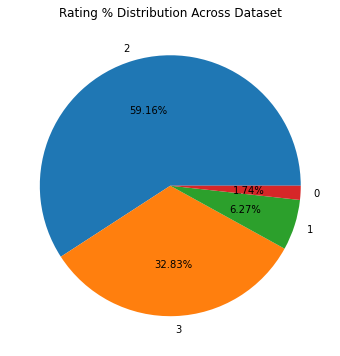

In [4]:
plt.figure(figsize = (20,6))
plt.pie(az["Sentiment"].value_counts(),labels = ["2","3","1","0"], autopct = "%1.2f%%")
plt.title("Rating % Distribution Across Dataset")
plt.show();

In [5]:
ct = pd.crosstab(az["Sentiment"], az["Product_Type"], margins = True)
ct

Product_Type,0,1,2,3,4,5,6,7,8,9,All
Sentiment,,,,,,,,,,,
0,0,0,2,1,0,0,2,0,1,105,111
1,4,5,69,49,0,36,84,43,65,44,399
2,1,1,15,10,0,6,16,8,6,3702,3765
3,47,53,379,240,19,171,563,276,122,219,2089
All,52,59,465,300,19,213,665,327,194,4070,6364


**Sentiment Word cloud**

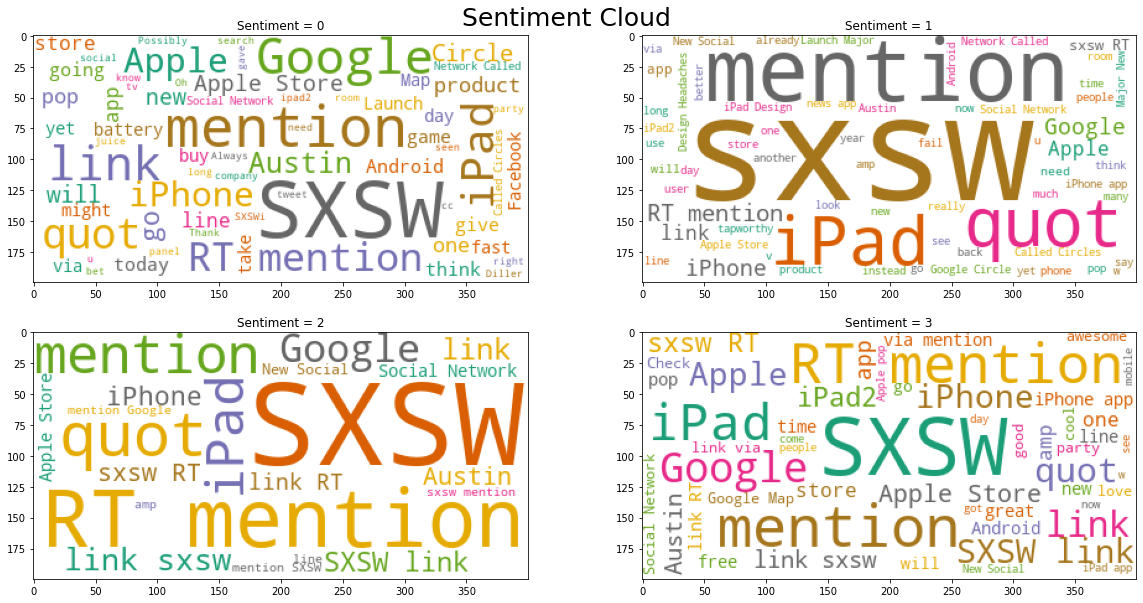

In [6]:
a_wc = WordCloud(max_words = 500, min_font_size = 8, colormap = "Dark2", background_color =
                 "white").generate(" ".join(az[az["Sentiment"] == 0].Product_Description))

b_wc = WordCloud(max_words = 500, min_font_size = 8, colormap = "Dark2", background_color =
                 "white").generate(" ".join(az[az["Sentiment"] == 1].Product_Description))

c_wc = WordCloud(max_words = 500, min_font_size = 8, colormap = "Dark2", background_color =
                 "white").generate(" ".join(az[az["Sentiment"] == 2].Product_Description))

d_wc = WordCloud(max_words = 500, min_font_size = 8, colormap = "Dark2", background_color =
                 "white").generate(" ".join(az[az["Sentiment"] == 3].Product_Description))

fig = plt.figure(figsize=(20,10))
plt.suptitle("Sentiment Cloud", size = 25, y = .92)

plt.subplot(2,2,1)
plt.imshow(a_wc)
plt.title("Sentiment = 0")

plt.subplot(2,2,2)
plt.imshow(b_wc)
plt.title("Sentiment = 1")

plt.subplot(2,2,3)
plt.imshow(c_wc)
plt.title("Sentiment = 2")

plt.subplot(2,2,4)
plt.imshow(d_wc)
plt.title("Sentiment = 3");

In [7]:
amazon = az.copy()
amazon["Product_Description"] = amazon["Product_Description"].values.astype(str)

**Text Pre-Processing**

In [8]:
def review_cleaning(text): 
    stop_words = stopwords.words('english')
    stop_words.extend(["sxsw","@","rt","re","w","u","m","s","sxswi","mention","link","amp","sx","sw","wi","sxs","google","app",
                       "phone","pad","apple","austin","quot","android","ipad","marissa","mayer","social","network","store",
                       "via","popup","called","zlf","zms","quotmajorquot"]) 
    
    text = normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore") # Encoding & Decoding Data
    text = contractions.fix(text)                                                 #Contraction Replacement
    text = re.sub("\[.*?\]","", text)                                             #brackets
    text = re.sub("https?://\S+|www\.\S+", "", text)                              #links
    text = re.sub("<.*?>+", "", text)                                             #characters
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)               #punctuations
    text = re.sub("\n","", text)                                                  #new line
    text = re.sub("\w*\d\w*","", text)                                            #numbers
    text = " ".join([s for s in re.split("([A-Z][a-z]+[^A-Z]*)",text) if s])      #Split attached Uppercase words
    text = "".join("".join(s)[:2] for _, s in itertools.groupby(text))            #remove letter repeating twice in continuation
    text = str(text).lower()                                                      #Normalization
    text = " ".join(s for s in str(text).split() if s not in stop_words)          #stopwords
    text = " ". join([w.lemmatize() for w in TextBlob(text).words])               #Lemmatizaion
    return text

In [9]:
amazon["Product_Description"] = amazon["Product_Description"].apply(review_cleaning)
amazon.head()

,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,web designer uas guide o apps today,9,2
1,6254,line longer today yesterday getting line today...,9,2
2,8212,crazy opening temporary tomorrow handle rabid ...,9,2
3,4422,lesson one pas digital environment user want p...,9,2
4,5526,panel mom designing boomersquot,9,2


**Sentimental Analysis**

In [10]:
amazon["word_count"] = amazon["Product_Description"].str.split().apply(len)
amazon["Polarity_score"] = amazon["Product_Description"].apply(lambda x:TextBlob(x).sentiment.polarity) #o/p lies between [-1,1]
amazon.head()

,Text_ID,Product_Description,Product_Type,Sentiment,word_count,Polarity_score
0,3057,web designer uas guide o apps today,9,2,7,0.0
1,6254,line longer today yesterday getting line today...,9,2,8,0.3
2,8212,crazy opening temporary tomorrow handle rabid ...,9,2,8,-0.6
3,4422,lesson one pas digital environment user want p...,9,2,14,0.0
4,5526,panel mom designing boomersquot,9,2,4,0.0


In [11]:
amazon.corr()

,Text_ID,Product_Type,Sentiment,word_count,Polarity_score
Text_ID,1.000000,0.033520,-0.004539,0.011462,-0.000580
Product_Type,0.033520,1.000000,-0.440887,-0.042410,-0.135590
Sentiment,-0.004539,-0.440887,1.000000,-0.026330,0.199620
word_count,0.011462,-0.042410,-0.026330,1.000000,0.122099
Polarity_score,-0.000580,-0.135590,0.199620,0.122099,1.000000


*It can be seen that Polarity_score contributes towards Sentiment having some corelation which can be useful variable for model building.*

In [12]:
amazon.pivot_table(index = ["Sentiment"], values = ["Polarity_score"], aggfunc = ["mean", "median"])

,mean,median
,Polarity_score,Polarity_score
Sentiment,,
0,0.078659,0.000000
1,0.022575,0.000000
2,0.101766,0.000000
3,0.211351,0.136364


In [13]:
amazon.iloc[:,4:].describe()

,word_count,Polarity_score
count,6364.000000,6364.000000
mean,7.391892,0.132370
std,3.003969,0.272196
min,0.000000,-1.000000
25%,5.000000,0.000000
50%,7.000000,0.000000
75%,10.000000,0.250000
max,23.000000,1.000000


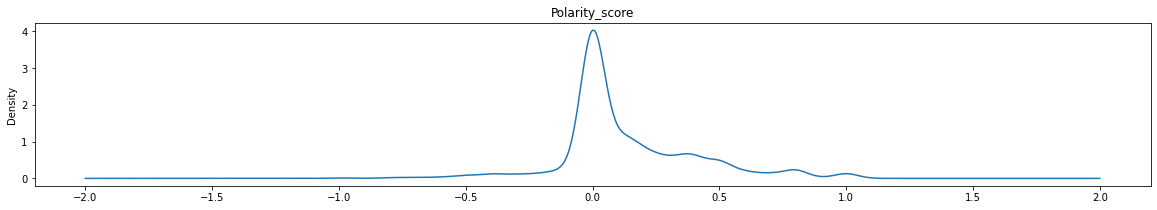

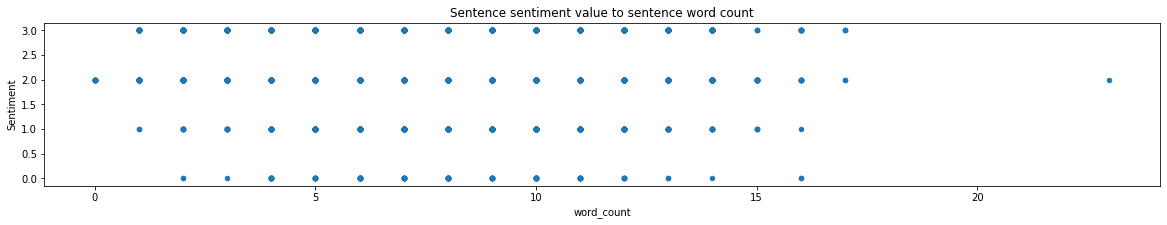

In [14]:
plt.figure(figsize = (20,3))
amazon["Polarity_score"].plot(kind = "kde", title = "Polarity_score")
amazon.plot.scatter(x = "word_count",y = "Sentiment",figsize = (20,3),title ="Sentence sentiment value to sentence word count");

**Word Cloud**

In [15]:
#defining word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud)  
    plt.axis("off");

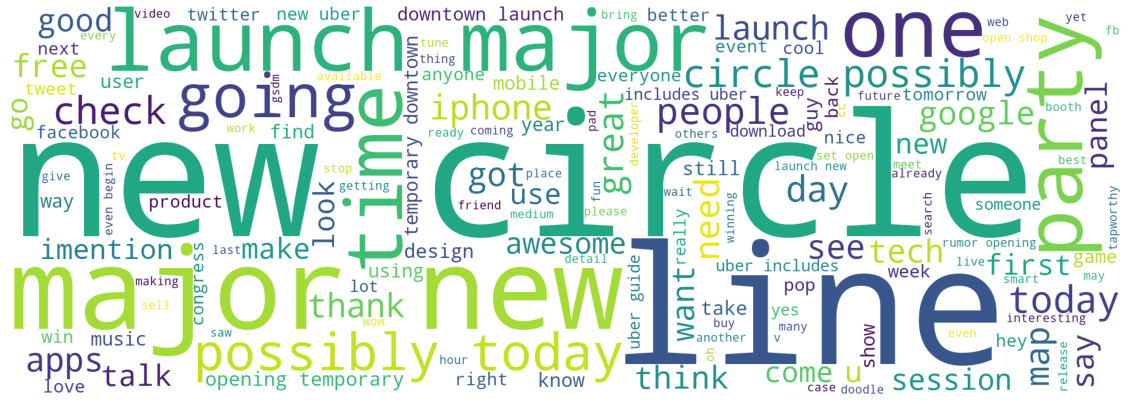

In [16]:
wc = " ".join(i for i in amazon["Product_Description"])
wordcloud = WordCloud(width = 2000, height = 700, min_font_size = 10, background_color = "white", max_words = 150).generate(wc)
plot_cloud(wordcloud);

**Feature Extraction**

**TF-IDF Vectorizer**

In [17]:
vectorizer_n_gram_max_features = TfidfVectorizer(norm = "l2", analyzer = "word", ngram_range = (1,3), max_features = 100)
tf_idf_matrix_n_gram_max_features = vectorizer_n_gram_max_features.fit_transform(amazon["Product_Description"])
print("Feature Names -",vectorizer_n_gram_max_features.get_feature_names_out())
print("\n","Matrix Size: ",tf_idf_matrix_n_gram_max_features.toarray().shape)

Feature Names - ['anyone' 'apps' 'around' 'awesome' 'best' 'big' 'bing' 'case' 'check'
 'circle' 'circle possibly' 'circle possibly today' 'come' 'coming' 'cool'
 'day' 'design' 'download' 'downtown' 'even' 'first' 'free' 'game' 'get'
 'go' 'going' 'good' 'google' 'got' 'great' 'guide' 'guy' 'imention'
 'iphone' 'know' 'last' 'launch' 'launch major' 'launch major new'
 'launching' 'like' 'line' 'location' 'look' 'love' 'major' 'major new'
 'major new circle' 'make' 'map' 'mobile' 'music' 'need' 'new'
 'new circle' 'new circle possibly' 'news' 'next' 'one' 'open' 'opening'
 'opening temporary' 'panel' 'party' 'people' 'pop' 'possibly'
 'possibly today' 'product' 'right' 'rumor' 'say' 'search' 'see' 'session'
 'set' 'shop' 'show' 'still' 'take' 'talk' 'team' 'tech' 'temporary'
 'thanks' 'thing' 'think' 'time' 'today' 'twitter' 'uber' 'use' 'user'
 'using' 'want' 'way' 'week' 'win' 'would' 'year']

 Matrix Size:  (6364, 100)


**Name Entity Recognition                                               
Entity Tagging**

In [18]:
nlp = spacy.load("en_core_web_sm")
doc_block = nlp(str(amazon["Product_Description"]))

#Filtering for adjectives only
adj = [token.text for token in doc_block if token.pos_ in ("ADJ")]
print(adj)

['crazy', 'digital', 'awesome', 'free', 'new']


**Model Building**

In [19]:
# split data into X and Y variables
Y = amazon["Sentiment"]
tf = TfidfVectorizer().fit_transform(amazon["Product_Description"]).toarray()
tf = pd.DataFrame(tf)

In [20]:
X = pd.concat((tf, amazon["Product_Type"], amazon["Polarity_score"]), axis = 1)
X.columns = X.columns.astype(str)
print(X.shape)
X.head()

(6364, 7592)


,0,1,2,3,4,5,6,7,8,9,...,7582,7583,7584,7585,7586,7587,7588,7589,Product_Type,Polarity_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,-0.6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.0


In [21]:
# Split-out validation dataset
validation_size = 0.20
seed = 45
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = validation_size, random_state = seed)
X_train.shape, X_test.shape

((5091, 7592), (1273, 7592))

In [22]:
# prepare models
models = []

models.append(("SVM", SVC()))
models.append(("XB", XGBClassifier()))
models.append(("AB", AdaBoostClassifier()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("GB", GradientBoostingClassifier()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits = 10)
    scoring = "accuracy"
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

SVM: 87.624562 (1.614202)                             
XB: 88.213953 (1.514852)            
AB: 87.231827 (1.055814)            
KNN: 87.958511 (1.445021)         
RF: 87.683539 (1.428929)           
CART: 83.971147 (1.567100)     
GB: 88.037097 (1.464561)

In [23]:
# Standardize the dataset
pipelines = []
pipelines.append(("ScaledSVM", Pipeline([("Scaler", StandardScaler()), ("SVM", SVC())])))
pipelines.append(("ScaledXB", Pipeline([("Scaler", StandardScaler()), ("XB", XGBClassifier())])))
pipelines.append(("ScaledSAB", Pipeline([("Scaler", StandardScaler()), ("AB", AdaBoostClassifier())])))
pipelines.append(("ScaledKNN", Pipeline([("Scaler", StandardScaler()), ("KNN", KNeighborsClassifier())])))
pipelines.append(("ScaledRF", Pipeline([("Scaler", StandardScaler()), ("RF", RandomForestClassifier())])))
pipelines.append(("ScaledCART", Pipeline([("Scaler", StandardScaler()), ("CART", DecisionTreeClassifier())])))
pipelines.append(("ScaledGB", Pipeline([("Scaler", StandardScaler()), ("GB", GradientBoostingClassifier())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits = 10)
    scoring = "accuracy"
    cv_results = cross_val_score(model, X_train, Y_train,cv = kfold,scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

ScaledSVM: 68.079934 (2.433506)                   
ScaledXB: 88.213953 (1.514852)                        
ScaledSAB: 87.231827 (1.055814)                  
ScaledKNN: 60.340999 (1.946099)                           
ScaledRF: 87.781733 (1.545121)                        
ScaledCART: 83.990716 (1.537848)                          
ScaledGB: 88.174583 (1.514685)

**`Fine tune SVM`**

In [24]:
param_dict = {"kernel_values":["poly", "rbf"], "gamma":[0.5, 0.1, "auto"]}

model_svm = SVC()
kfold = KFold(n_splits = 10)
scoring = "accuracy"

grid = GridSearchCV(estimator = model_svm, param_grid = param_dict, scoring = scoring, cv = kfold)

grid_result_svm = grid.fit(X_train, Y_train)

print("Best: %f using %s" %(grid_result_svm.best_score_, grid_result_svm.best_params_))

**Best: 0.881156 using {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}** 

In [25]:
# applying SVC parameters on train models based on GridSearchCV Results
model_svm = SVC(C = 1, kernel = "rbf", gamma = 0.5)
model_svm.fit(X_train, Y_train)

#Predicting on test data
preds_svm = model_svm.predict(X_test)

print("\nModel score",round(model_svm.score(X_test, Y_test)*100,4),"%"
      "\nClassification Report -\n",classification_report(Y_test, preds_svm))


Model score 88.531 %
Classification Report -
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       1.00      0.18      0.31        87
           2       0.92      0.98      0.95       767
           3       0.82      0.91      0.86       400

    accuracy                           0.89      1273
   macro avg       0.69      0.52      0.53      1273
weighted avg       0.88      0.89      0.86      1273



**`Fine tune XGBM`**

In [26]:
param_dict = {"n_estimators":[30,40,50],"max_depth":range(1,5),"gamma":[0.01,0.1,"auto"]}

model_xgb = XGBClassifier()
kfold = KFold(n_splits = 10)
scoring = "accuracy"

grid = GridSearchCV(estimator = model_xgb, param_grid = param_dict, scoring = scoring, cv = kfold)

grid_result_xgb = grid.fit(X_train, Y_train)

print("Best: %f using %s" %(grid_result_xgb.best_score_, grid_result_xgb.best_params_))

**Best: 0.884693 using {'gamma': 0.1, 'max_depth': 4, 'n_estimators': 50}**

In [27]:
# applying XGBM parameters on train models based on GridSearchCV Results
model_xgb = XGBClassifier(n_estimators = 50, max_depth = 4, gamma = 0.1)
model_xgb.fit(X_train,Y_train, sample_weight = compute_sample_weight("balanced", Y_train))

#Predicting on test data
preds_xgb = model_xgb.predict(X_test)

print("\nModel score",round(model_xgb.score(X_test, Y_test)*100,4),"%",
      "\nClassification Report -\n",classification_report(Y_test, preds_xgb))


Model score 83.0322 % 
Classification Report -
               precision    recall  f1-score   support

           0       0.08      0.26      0.12        19
           1       0.45      0.51      0.48        87
           2       0.92      0.90      0.91       767
           3       0.88      0.79      0.83       400

    accuracy                           0.83      1273
   macro avg       0.58      0.62      0.58      1273
weighted avg       0.86      0.83      0.85      1273



**`Fine Tune AB`**

In [28]:
param_dict = {"learning_rate":[0.1,0.01]}

model_ab = AdaBoostClassifier(random_state = seed)
kfold = KFold(n_splits = 10)
scoring = "accuracy"
seed = 45

grid = GridSearchCV(estimator = model_ab, param_grid = param_dict, scoring = scoring, cv = kfold)

grid_result_ab = grid.fit(X_train, Y_train)

print("Best: %f using %s" %(grid_result_ab.best_score_, grid_result_ab.best_params_))

**Best: 0.876246 using {'learning_rate': 0.01}**

In [29]:
# applying AB parameters on train models based on GridSearchCV Results
model_ab = AdaBoostClassifier(learning_rate = 0.01, random_state = 45)

model_ab.fit(X_train, Y_train)

#Predicting on test data
preds_ab = model_ab.predict(X_test)

print("\nModel score",round(model_ab.score(X_test, Y_test)*100,4),"%",
      "\nClassification Report -\n",classification_report(Y_test, preds_ab))


Model score 87.2742 % 
Classification Report -
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        87
           2       0.92      0.98      0.95       767
           3       0.80      0.91      0.85       400

    accuracy                           0.87      1273
   macro avg       0.43      0.47      0.45      1273
weighted avg       0.80      0.87      0.84      1273



**`Fine Tune KNN`**

In [30]:
param_dict = {"n_neighbors":range(1,10)}

model_knn = KNeighborsClassifier()
kfold = KFold(n_splits = 10)
scoring = "accuracy"

grid = GridSearchCV(estimator = model_knn, param_grid = param_dict, scoring = scoring, cv = kfold)

grid_result_knn = grid.fit(X_train, Y_train)

print("Best: %f using %s" %(grid_result_knn.best_score_, grid_result_knn.best_params_))

**Best: 0.883318 using {'n_neighbors': 8}**

In [31]:
# applying KNN parameters on train models based on GridSearchCV Results
model_knn = KNeighborsClassifier(n_neighbors = 8)
model_knn.fit(X_train, Y_train)

#Predicting on test data
preds_knn = model_knn.predict(X_test)

print("\nModel score",round(model_knn.score(X_test, Y_test)*100,4),"%",
      "\nClassification Report -\n",classification_report(Y_test, preds_knn))


Model score 88.4525 % 
Classification Report -
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.74      0.26      0.39        87
           2       0.91      0.98      0.94       767
           3       0.84      0.89      0.86       400

    accuracy                           0.88      1273
   macro avg       0.62      0.53      0.55      1273
weighted avg       0.86      0.88      0.87      1273



**Fine tune Random Forest**

In [32]:
param_dict = {"n_estimators":[30,35,40], "max_depth":range(1,5), "max_features":["auto"]}

model_rf = RandomForestClassifier()
kfold = KFold(n_splits = 10)
scoring = "accuracy"

grid = GridSearchCV(estimator = model_rf, param_grid = param_dict, scoring = scoring, cv = kfold)

grid_result_rf = grid.fit(X_train, Y_train)

print("Best: %f using %s" %(grid_result_rf.best_score_, grid_result_rf.best_params_))

**Best: 0.591821 using {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 40}**

In [33]:
# applying RF parameters on train models based on GridSearchCV Results
model_rf = RandomForestClassifier(n_estimators = 40, max_depth = 4 , max_features = "auto")
model_rf.fit(X_train, Y_train)

#Predicting on test data
preds_rf = model_rf.predict(X_test)

print("\nModel score",round(model_rf.score(X_test, Y_test)*100,4),"%",
      "\nClassification Report -\n",classification_report(Y_test, preds_rf))


Model score 60.2514 % 
Classification Report -
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        87
           2       0.60      1.00      0.75       767
           3       0.00      0.00      0.00       400

    accuracy                           0.60      1273
   macro avg       0.15      0.25      0.19      1273
weighted avg       0.36      0.60      0.45      1273



**`Fine Tune Decision Tree`**

In [34]:
param_dict = {"criterion":["entropy","gini"], "max_depth":range(1,5), "max_features":["auto","sqrt"]}

model_dt = DecisionTreeClassifier()
kfold = KFold(n_splits = 10)
scoring = "accuracy"

grid = GridSearchCV(estimator = model_dt, param_grid = param_dict, scoring = scoring, cv = kfold)

grid_result_dt = grid.fit(X_train, Y_train)

print("Best: %f using %s" %(grid_result_dt.best_score_, grid_result_dt.best_params_))

**Best: 0.619523 using {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto'}**

In [35]:
# applying DT parameters on train models based on GridSearchCV Results
model_dt = DecisionTreeClassifier(criterion = "gini", max_depth = 3 , max_features = "auto")
model_dt.fit(X_train, Y_train)

#Predicting on test data
preds_dt = model_dt.predict(X_test)

print("\nModel score",round(model_dt.score(X_test, Y_test)*100,4),"%",
      "\nClassification Report -\n",classification_report(Y_test, preds_dt))


Model score 60.2514 % 
Classification Report -
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        87
           2       0.60      1.00      0.75       767
           3       0.38      0.01      0.01       400

    accuracy                           0.60      1273
   macro avg       0.24      0.25      0.19      1273
weighted avg       0.48      0.60      0.46      1273



**`Fine Tune Gradient Boosting`**

In [36]:
param_dict = {"n_estimators":[30,40,50,80], "max_depth":range(1,5), "max_features":["auto","sqrt"]}

model_gb = GradientBoostingClassifier()
kfold = KFold(n_splits = 10)
scoring = "accuracy"

grid = GridSearchCV(estimator = model_gb, param_grid = param_dict, scoring = scoring, cv = kfold)

grid_result_gb = grid.fit(X_train, Y_train)

print("Best: %f using %s" %(grid_result_gb.best_score_, grid_result_gb.best_params_))

**Best: 0.881353 using {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 90}**

In [37]:
# applying GB parameters on train models based on GridSearchCV Results
model_gb = GradientBoostingClassifier(n_estimators = 90, max_depth = 3, max_features = "auto")
model_gb.fit(X_train, Y_train)

#Predicting on test data
preds_gb = model_gb.predict(X_test)

print( "\nModel score",round(model_gb.score(X_test, Y_test)*100,4),"%",
    "\nClassification Report -\n",classification_report(Y_test, preds_gb))


Model score 87.5884 % 
Classification Report -
               precision    recall  f1-score   support

           0       0.05      0.05      0.05        19
           1       0.79      0.22      0.34        87
           2       0.92      0.96      0.94       767
           3       0.84      0.89      0.86       400

    accuracy                           0.88      1273
   macro avg       0.65      0.53      0.55      1273
weighted avg       0.87      0.88      0.86      1273



In [38]:
#Compare the model Accuracy 
data = {"Classifier":pd.Series(["SVM","XGBM","AB","KNN","RF","CART","GB"]),
        "Model score":pd.Series([model_svm.score(X_test, Y_test),model_xgb.score(X_test, Y_test),model_ab.score(X_test, Y_test),
                              model_knn.score(X_test, Y_test),model_rf.score(X_test, Y_test),model_dt.score(X_test, Y_test),
                              model_gb.score(X_test, Y_test)])}
classy = pd.DataFrame(data)
classy

,Classifier,Model score
0,SVM,0.885310
1,XGBM,0.830322
2,AB,0.872742
3,KNN,0.884525
4,RF,0.602514
5,CART,0.602514
6,GB,0.875884


In [39]:
data = {"Precision":{"SVM":{"0":0.00,"1":1.00,"2":0.92,"3":0.82},"XGBM":{"0":0.08,"1":0.45,"2":0.92,"3":0.88},
                     "AB":{"0":0.00,"1":0.00,"2":0.92,"3":0.80},"KNN":{"0":0.00,"1":0.74,"2":0.91,"3":0.84},
                     "RF":{"0":0.00,"1":0.00,"2":0.60,"3":0.00},"CART":{"0":0.00,"1":0.00,"2":0.60,"3":0.38},
                     "GB":{"0":0.05,"1":0.79,"2":0.92,"3":0.84}},
        "Recall":{"SVM":{"0":0.00,"1":0.18,"2":0.98,"3":0.91},"XGBM":{"0":0.26,"1":0.51,"2":0.90,"3":0.79},
                  "AB":{"0":0.00,"1":0.00,"2":0.98,"3":0.91},"KNN":{"0":0.00,"1":0.26,"2":0.98,"3":0.89},
                  "RF":{"0":0.00,"1":0.00,"2":1.00,"3":0.00},"CART":{"0":0.00,"1":0.00,"2":1.00,"3":0.01},
                  "GB":{"0":0.05,"1":0.22,"2":0.96,"3":0.89}},
        "F1":{"SVM":{"0":0.00,"1":0.31,"2":0.95,"3":0.86},"XGBM":{"0":0.12,"1":0.48,"2":0.91,"3":0.83},
              "AB":{"0":0.00,"1":0.00,"2":0.95,"3":0.85},"KNN":{"0":0.00,"1":0.39,"2":0.94,"3":0.86},
              "RF":{"0":0.00,"1":0.00,"2":0.75,"3":0.00},"CART":{"0":0.00,"1":0.00,"2":0.75,"3":0.01},
              "GB":{"0":0.05,"1":0.34,"2":0.94,"3":0.86}},
        "Model_score":{"SVM":0.885310,"XGBM":0.830322,"AB":0.872742,"KNN":0.884525,"RF":0.602514,"CART":0.602514,"GB":0.875884}}
data = pd.DataFrame(data)
data.sort_values(by = "Model_score", ascending = False)

,Precision,Recall,F1,Model_score
SVM,"{'0': 0.0, '1': 1.0, '2': 0.92, '3': 0.82}","{'0': 0.0, '1': 0.18, '2': 0.98, '3': 0.91}","{'0': 0.0, '1': 0.31, '2': 0.95, '3': 0.86}",0.885310
KNN,"{'0': 0.0, '1': 0.74, '2': 0.91, '3': 0.84}","{'0': 0.0, '1': 0.26, '2': 0.98, '3': 0.89}","{'0': 0.0, '1': 0.39, '2': 0.94, '3': 0.86}",0.884525
GB,"{'0': 0.05, '1': 0.79, '2': 0.92, '3': 0.84}","{'0': 0.05, '1': 0.22, '2': 0.96, '3': 0.89}","{'0': 0.05, '1': 0.34, '2': 0.94, '3': 0.86}",0.875884
AB,"{'0': 0.0, '1': 0.0, '2': 0.92, '3': 0.8}","{'0': 0.0, '1': 0.0, '2': 0.98, '3': 0.91}","{'0': 0.0, '1': 0.0, '2': 0.95, '3': 0.85}",0.872742
XGBM,"{'0': 0.08, '1': 0.45, '2': 0.92, '3': 0.88}","{'0': 0.26, '1': 0.51, '2': 0.9, '3': 0.79}","{'0': 0.12, '1': 0.48, '2': 0.91, '3': 0.83}",0.830322
RF,"{'0': 0.0, '1': 0.0, '2': 0.6, '3': 0.0}","{'0': 0.0, '1': 0.0, '2': 1.0, '3': 0.0}","{'0': 0.0, '1': 0.0, '2': 0.75, '3': 0.0}",0.602514
CART,"{'0': 0.0, '1': 0.0, '2': 0.6, '3': 0.38}","{'0': 0.0, '1': 0.0, '2': 1.0, '3': 0.01}","{'0': 0.0, '1': 0.0, '2': 0.75, '3': 0.01}",0.602514


## Final Model

*Since the data is imbalance XGBoost gives highest F1 score for each class, we train our final based on XGBClassifier*           

In [41]:
final_model = XGBClassifier()
final_model.fit(X, Y, sample_weight = compute_sample_weight("balanced", Y))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

**Saving the Model**

In [42]:
dump(final_model, open("Amazon.sav", "wb"))
loaded_model = load(open("Amazon.sav", "rb"))
result = loaded_model.score(X, Y)
print(round(result*100,4))

93.6832
